In [1]:
################################################
### all the packages we need are defined here ##
################################################
using Logging
using Dates
using CSV
using DataFrames
using JLD2
using FileIO
using DataFrames
using Plots 
using CSV
using Distributions
using Random
using DifferentialEquations
using Tables
using DelimitedFiles
using BSON: @save, @load

In [2]:
include("SSDoutputs/allMutSims/basal_cRelSynth-linking_1.5/modelFiles/odeMultiscaleModel.jl")

odeMultiscaleModel! (generic function with 1 method)

In [3]:
mutable struct cell
    generation::Int64
    ID::Int64
    motherCellID::Int64
    founderCellID::Int64
    ODEFile::String
    fate::Int64 #0 = unknown, 1 = division, 2 = death
    tBirth::Float64
    tDeath::Float64
    solutionObject #the entire solution object. If you don't need this comment it out for efficiency.
    y0::Matrix{Float64} #initial conditions.
    yCoord::Float64 #for plotting lineage trees
    leftDaughterID::Int64
    rightDaughterID::Int64
    parameterList
    parameterNameList::Vector{String}
    cellsRepresented::Int64
    #newSwitch::Int64
end    

In [4]:
# function getIndexesToPlot(speciesToPlot)
#     indexesToPlot=[]
#     for (index,species) in enumerate(speciesToPlot)

#         #print(species)
#         thisIndex=findfirst(x->species==x,syms)
#         append!(indexesToPlot,thisIndex)
#     end
#     return(indexesToPlot)
# end

In [4]:
#### Load patient data
patient_data = DataFrame(CSV.File("peakValsMetsDF.csv"))

,timestamp,cMyct,RelAnp50n,cRelnp50n,Bcl2t,Cycdt,tcRel,RelAnp52n
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,361.0,11.1351,22.7404,11.8283,87.0506,0.158179,0.0456584,1.21969
2,361.0,11.1353,22.7406,11.8284,122.372,0.158179,0.0456584,1.2197
3,361.0,11.1351,22.7404,11.8283,87.0506,0.158179,0.0456584,1.21969
4,361.0,11.0332,22.7305,11.3198,121.554,0.157671,0.0327029,1.23965
5,361.0,10.1082,25.9377,8.93074,135.192,0.174912,0.0434588,1.5552
6,361.0,11.4278,22.8413,12.679,89.5524,0.161907,0.0476666,1.21196
7,361.0,6.95797,15.8112,6.05702,90.7254,0.102658,0.0408734,1.45913
8,361.0,11.1351,22.7411,11.8287,87.0505,0.158179,0.0456584,1.21972
9,361.0,11.1352,22.7411,11.8288,122.371,0.15818,0.0456584,1.21972


In [5]:
patients = unique(patient_data.patient_ID)

113-element Vector{String31}:
 "DLBCL-LS1899"
 "DLBCL-LS4593"
 "DLBCL-RICOVER_910"
 "DLBCL-LS1546"
 "DLBCL-LS3809"
 "DLBCL-LS3085"
 "DLBCL-LS3820"
 "DLBCL-LS3866"
 "DLBCL-RICOVER_338"
 "DLBCL-RICOVER_711"
 "DLBCL-DFCI_DLBCL_Goe16"
 "DLBCL-LS155"
 "DLBCL-LS1620"
 ⋮
 "DLBCL-LS2325"
 "DLBCL-LS3245"
 "DLBCL-LS4619"
 "DLBCL-RICOVER_533"
 "DLBCL-RICOVER_1237"
 "DLBCL-LS146"
 "DLBCL-RICOVER_1263"
 "DLBCL-RICOVER_720"
 "DLBCL-RICOVER_401"
 "DLBCL-LS1683"
 "DLBCL-LS2328"
 "DLBCL-LS3309"

In [6]:
#### Mut/Param data
muts2Params = DataFrame(CSV.File("muts2ParamsNEW.csv"))
# concatenate gene and alteration
muts2Params[!, "GeneAlt"] = string.(muts2Params[!, "GENE"], ":", muts2Params[!, "ALTERATION"])
## remove zeros
muts2Params = muts2Params[(muts2Params.PARAMETER .!= "0"), :];

In [7]:
#### Load combined output data
CombOp = DataFrame(CSV.File("combinedOutput2_noDupes_cleanedUpStructVars.csv"))
# remove missing data
CombOp = CombOp[completecases(CombOp), :]
# concatenate gene and alteration
CombOp[!, "GeneAlt"] = string.(CombOp[!, "GENE"], ":", CombOp[!, "ALTERATION"]);

In [8]:
# create mut dictionary
param_mut=Dict() 
# populate mut dictionary
for i in 1:nrow(muts2Params)
    GeneAlt = muts2Params[i,:GeneAlt]
    Param = muts2Params[i,:PARAMETER]
    param_mut[GeneAlt]=Param
end    

In [9]:
# create vals dictionary
param_vals=Dict()
# populate vals dictionary
for i in 1:nrow(muts2Params)
    GeneAlt = muts2Params[i,:GeneAlt]
    Val = muts2Params[i,:AMOUNT]
    param_vals[GeneAlt]=Val
end    

In [10]:
# create gene:alt dictionary
gene_alt=Dict() 
# populate mut dictionary
for i in 1:nrow(muts2Params)
    GeneAlt = muts2Params[i,:GeneAlt]
    Param = muts2Params[i,:PARAMETER]
    gene_alt[Param]=GeneAlt
end    

In [11]:
function GenConds(muts)
    Conds = DataFrame(Param = Any[], Val = Float64[])
        for i in 1:length(muts)        
            # check genes are in dictionary
            if haskey(param_mut, muts[i]) == true
                mut=muts[i]
                val=param_vals[mut]
                param=param_mut[mut]
                ParamVal = DataFrame(Param=param, Val=val)
                append!(Conds, ParamVal)
            else 
                continue
            end
        end
    return(Conds)
end

GenConds (generic function with 1 method)

In [12]:
function GenConds2(muts_count)
    p2C=[]
    mA=[]
    for i in 1:nrow(muts_count)
        param=muts_count[i,1]
        push!(p2C, param)
        val=muts_count[i,2]
        NUM=muts_count[i,3]
        PV=val^NUM
        push!(mA, PV)
    end
    return(p2C, mA)
end        

GenConds2 (generic function with 1 method)

In [13]:
cA=palette(:seaborn_colorblind, 20)

In [14]:
speciesDict = Dict()
speciesDict["cMyct"] = 2
speciesDict["Bcl2t"] = 5
speciesDict["RelAnp50n"] = 3

3

In [15]:
# get data for individual patient
function getPatConds(patient)
    patient_df = CombOp[(CombOp.PATIENT .== patient), :]
    
    # get mutations
    muts = Vector(patient_df[!, :GeneAlt])
    conds = GenConds(muts)
    muts_count = combine(groupby(conds, [:Param, :Val]), nrow => :count)
    ######################
    ### Set conditions ###
    ######################
    
    # set patient name
#     patient = patient_df[1,1]
    
    conditions = ["all_mut"]
    
    # get conditions
    conds_run = GenConds2(muts_count)
    
    condsToPlot = Any["WT"]
    params = conds_run[1]
    values = conds_run[2]
    
    for i in 1:length(conds_run[1])
        folderName = string.(params[i], "_", values[i])
        push!(condsToPlot, folderName)
    end
    push!(condsToPlot, "all_mut")
    
    GeneAlt = Any["WT"]
    for i in 1:length(params)
        if haskey(param_mut, muts[i]) == true  ### THIS
        label = muts[i] ## edited so that the correct label is selected (not just the first one)    
        println(muts[i]*" pushed to list")
        else 
            println(muts[i]*" is not in the dictionary")
            i=i-1
        end
    end
    push!(GeneAlt, "All mutations")
    return(condsToPlot, GeneAlt, conds_run)
end

getPatConds (generic function with 1 method)

In [47]:
conds_test = getPatConds("DLBCL-LS4593")

BAD:AMP pushed to list
RB1:HETLOSS pushed to list
XIAP:G188E is not in the dictionary


(Any["WT", "k1_81-apoptosis_1.5", "k1_26-cellCycle_0.5", "k1_bcl2Exp-linking_1.5", "all_mut"], Any["WT", "All mutations"], (Any["k1_81-apoptosis", "k1_26-cellCycle", "k1_bcl2Exp-linking"], Any[1.5, 0.5, 1.5]))

In [11]:
sims = readdir("SSDoutputs/allMutSims")

254-element Vector{String}:
 "DLBCL-BWH_DLBCL64"
 "DLBCL-DFCI_DLBCL_GOE05"
 "DLBCL-DFCI_DLBCL_GOE07"
 "DLBCL-DFCI_DLBCL_GOE16"
 "DLBCL-DFCI_DLBCL_Goe05"
 "DLBCL-DFCI_DLBCL_Goe16"
 "DLBCL-LS1065"
 "DLBCL-LS1098"
 "DLBCL-LS1304"
 "DLBCL-LS1395"
 "DLBCL-LS146"
 "DLBCL-LS148"
 "DLBCL-LS1546"
 ⋮
 "k1_tIkBb-NFkB_1.5"
 "k2_1a-cellCycle_1.5"
 "k2_5-cellCycle_0.5"
 "k2_IKK_1,5_orig"
 "k2_scalingNumber-NFkB_1.5"
 "k2_scalingNumber-NFkB_2.25"
 "k2_scalingNumber-NFkB_3.375"
 "k3_7-cellCycle"
 "k3_7-cellCycle_1.5"
 "kmax_IkBaSynth-NFkB_0.5"
 "kmax_IkBeSynth-NFkB_1.5"
 "logs"

In [21]:
setdiff!(sims, ["indivParams2"])

250-element Vector{String}:
 "DLBCL-BWH_DLBCL64"
 "DLBCL-DFCI_DLBCL_GOE05"
 "DLBCL-DFCI_DLBCL_GOE07"
 "DLBCL-DFCI_DLBCL_GOE16"
 "DLBCL-DFCI_DLBCL_Goe05"
 "DLBCL-DFCI_DLBCL_Goe16"
 "DLBCL-LS1065"
 "DLBCL-LS1098"
 "DLBCL-LS1304"
 "DLBCL-LS1395"
 "DLBCL-LS146"
 "DLBCL-LS148"
 "DLBCL-LS1546"
 ⋮
 "k1_s_IRF4-linking_0.5"
 "k1_tIkBb-NFkB_1.5"
 "k2_1a-cellCycle_1.5"
 "k2_5-cellCycle_0.5"
 "k2_IKK_1,5_orig"
 "k2_scalingNumber-NFkB_1.5"
 "k2_scalingNumber-NFkB_2.25"
 "k2_scalingNumber-NFkB_3.375"
 "k3_7-cellCycle"
 "k3_7-cellCycle_1.5"
 "kmax_IkBaSynth-NFkB_0.5"
 "kmax_IkBeSynth-NFkB_1.5"

In [18]:
function loadCells(patient, sim, cell_number) 
    if sim == "all_mut"
        path = "SSDoutputs/allMutSims/"*patient*"/all_mut/processedCells/cell_"*string(cell_number)*".jld2"
    else 
        path = "SSDoutputs/allMutSims/indivParams/"*sim*"/mut/processedCells/cell_"*string(cell_number)*".jld2"
    end
    @load path thisCell
    cellDF = thisCell.solutionObject
    
    return(cellDF)
end

loadCells (generic function with 1 method)

In [19]:
function loadCells(sim) 
    path = "SSDoutputs/test_121023/"*sim*"/processedCells/cell_1.jld2"
    @load path thisCell
    cellDF = thisCell.solutionObject    
    return(cellDF)
end

loadCells (generic function with 1 method)

In [24]:
for sim in sims
    if startswith(sim, "DLBCL") == true
        path = "SSDoutputs/allMutSims/"*sim*"/all_mut/processedCells/cell_1.jld2"
    else
        path = "SSDoutputs/allMutSims/"*sim*"/mut/processedCells/cell_1.jld2"
    end
    try
        @load path thisCell
        cellDF = thisCell.solutionObject
        CSV.write("sim_DFs/"*sim*"_SimDF.csv", cellDF)
        println(sim*" DF saved")
    catch
        println("can't load "*sim)
    end
end

DLBCL-BWH_DLBCL64 DF saved
DLBCL-DFCI_DLBCL_GOE05 DF saved
DLBCL-DFCI_DLBCL_GOE07 DF saved
DLBCL-DFCI_DLBCL_GOE16 DF saved
DLBCL-DFCI_DLBCL_Goe05 DF saved
DLBCL-DFCI_DLBCL_Goe16 DF saved
DLBCL-LS1065 DF saved
DLBCL-LS1098 DF saved
DLBCL-LS1304 DF saved
DLBCL-LS1395 DF saved
DLBCL-LS146 DF saved
DLBCL-LS148 DF saved
DLBCL-LS1546 DF saved
DLBCL-LS155 DF saved
DLBCL-LS1583 DF saved
DLBCL-LS1620 DF saved
DLBCL-LS1668 DF saved
DLBCL-LS1683 DF saved
DLBCL-LS1757 DF saved
DLBCL-LS1899 DF saved
DLBCL-LS1921 DF saved
DLBCL-LS2089 DF saved
DLBCL-LS2208 DF saved
DLBCL-LS2245 DF saved
DLBCL-LS2258 DF saved
DLBCL-LS2264 DF saved
DLBCL-LS2305 DF saved
DLBCL-LS2325 DF saved
DLBCL-LS2328 DF saved
DLBCL-LS2357 DF saved
DLBCL-LS2367 DF saved
DLBCL-LS2590 DF saved
DLBCL-LS2596 DF saved
DLBCL-LS2599 DF saved
DLBCL-LS297 DF saved
DLBCL-LS2978 DF saved
DLBCL-LS3085 DF saved
DLBCL-LS3200 DF saved
DLBCL-LS3204 DF saved
DLBCL-LS3245 DF saved
DLBCL-LS3271 DF saved
DLBCL-LS3309 DF saved
DLBCL-LS3387 DF saved
DLB

In [37]:
function PlotNFKB(patient, species, time_limit)
    n=1
    p = plot()
    conds = getPatConds(patient)
    sims = conds[1]
    println(sims)
    muts = conds[2]
    println(muts)
    
    for i=1:length(sims)
        try
        cellDF = loadCells(patient, sims[i], 10)
            if sims[i] == "WT"
                plot!(cellDF.timestamp, cellDF[:, speciesDict[species]], lc=:blue, lw=10, label="WT",
                    legend = :outertopright, size=(900,600),
                    title = species*" in simulations for "*patient,
                    xlabel = "time (hours)", ylabel = species*" value",
                    xlim = (0,60*time_limit),
                    xticks = (0:60*1:60*time_limit, string.(0:1:time_limit)))
            elseif sims[i] == "all_mut"
                plot!(cellDF.timestamp, cellDF[:, speciesDict[species]], lc=:black, lw=10, label="All mutations")
            else 
                plot!(cellDF.timestamp, cellDF[:, speciesDict[species]], lc=cA[n], lw=2.5, label=muts[i])
            end
            n=n+2
        catch
            println(sims[i]*" can't be loaded ")
        end
    end
    display(p)
end

PlotNFKB (generic function with 2 methods)

In [46]:
colours = [:blue :orange :purple :green]

1×4 Matrix{Symbol}:
 :blue  :orange  :purple  :green

In [44]:
function PlotNFKB(species, time_limit) #patient, 
    n=1
    p = plot()
#     conds = getPatConds(patient)
    patient = "test"
    conds = pat1_conds
    sims = conds[1]
    println(sims)
    muts = conds[2]
    println(muts)
    
    for i=1:length(sims)
        try
        cellDF = loadCells(sims[i])
            if sims[i] == "WT"
                plot!(cellDF.timestamp, cellDF[:, speciesDict[species]], lc=:blue, lw=10, label="WT",
                    legend = :outertopright, size=(900,600),
                    title = species*" in simulations for "*patient,
                    xlabel = "time (hours)", ylabel = species*" value",
                    xlim = (0,60*time_limit),
                    xticks = (0:60*1:60*time_limit, string.(0:1:time_limit)))
            elseif sims[i] == "all_mut"
                plot!(cellDF.timestamp, cellDF[:, speciesDict[species]], lc=:black, lw=10, label="All mutations")
            else 
                plot!(cellDF.timestamp, cellDF[:, speciesDict[species]], lc=colours[n], lw=2.5, label=muts[i])
            end
            n=n+1
        catch
            println(sims[i]*" can't be loaded ")
        end
    end
    display(p)
#     savefig(p, "NF-kB_Myc_Bcl2/Plots/"*patient*"_"*species*"_plot.png")
end

PlotNFKB (generic function with 2 methods)

In [27]:
pat1_conds = [["WT", "Myc_x1.5", "Bcl2_x1.5", "IKK_x1.5"],
                ["WT", "Myc_mut", "Bcl2_mut", "IKK_mut",]]

2-element Vector{Vector{String}}:
 ["WT", "Myc_x1.5", "Bcl2_x1.5", "IKK_x1.5"]
 ["WT", "Myc_mut", "Bcl2_mut", "IKK_mut"]

["WT", "Myc_x1.5", "Bcl2_x1.5", "IKK_x1.5"]
["WT", "Myc_mut", "Bcl2_mut", "IKK_mut"]


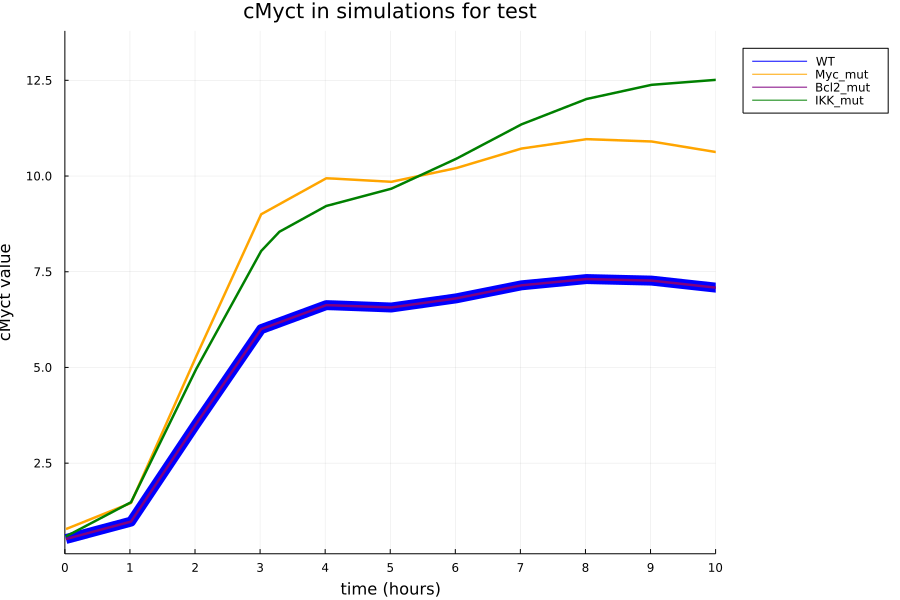

["WT", "Myc_x1.5", "Bcl2_x1.5", "IKK_x1.5"]
["WT", "Myc_mut", "Bcl2_mut", "IKK_mut"]


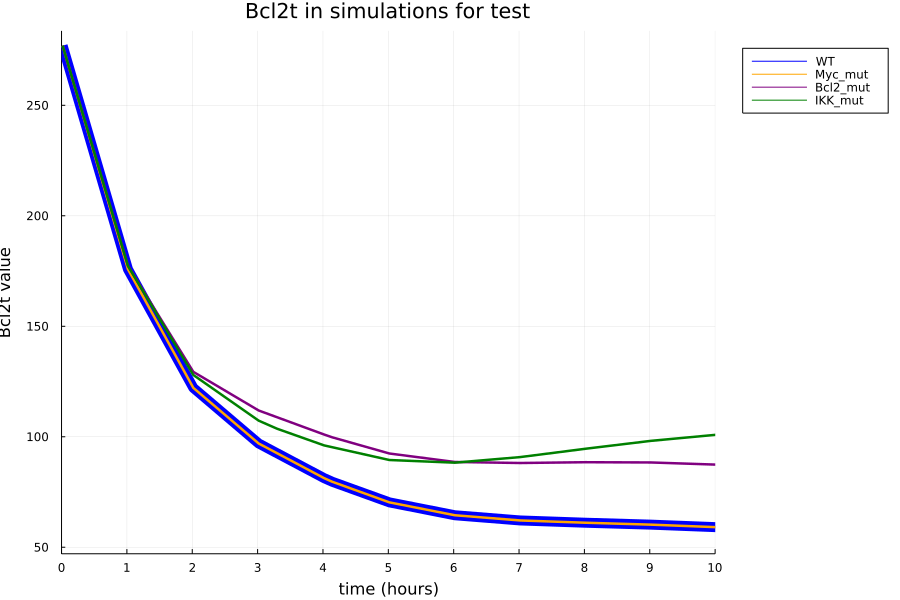

["WT", "Myc_x1.5", "Bcl2_x1.5", "IKK_x1.5"]
["WT", "Myc_mut", "Bcl2_mut", "IKK_mut"]


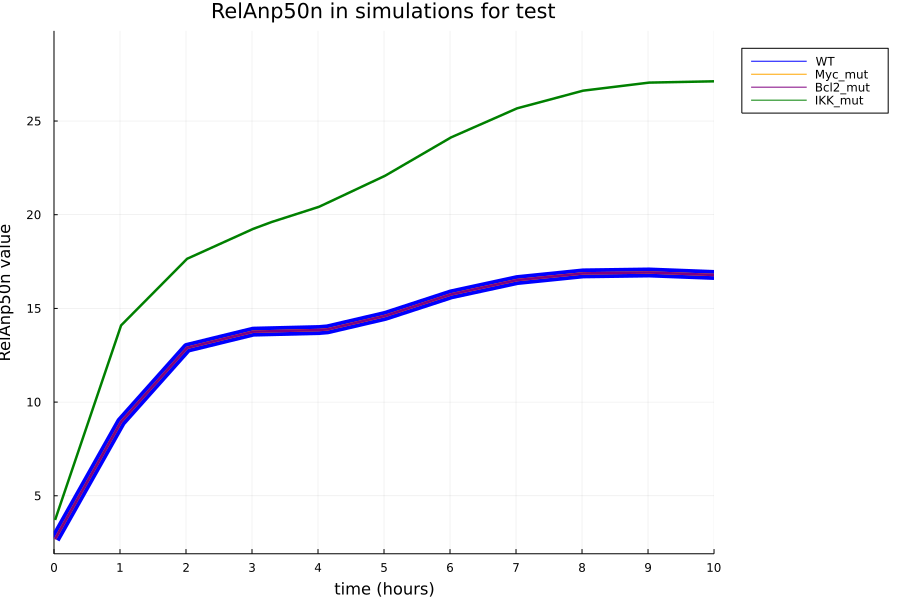

In [47]:
species = ["cMyct", "Bcl2t", "RelAnp50n"]

for i in species
    PlotNFKB(i, 10)
end

Any["WT", "k2_1a-cellCycle_1.5", "k1_113-apoptosis_1.5", "all_mut"]
Any["WT", "CCNB1:AMP", "CYCS:AMP", "All mutations"]


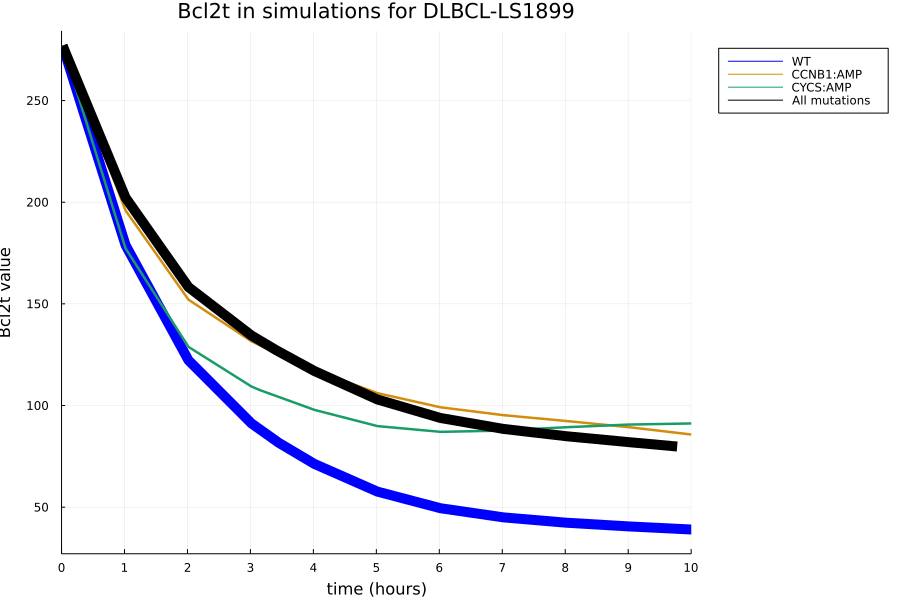

Any["WT", "k1_81-apoptosis_1.5", "k1_26-cellCycle_0.5", "k1_bcl2Exp-linking_1.5", "all_mut"]
Any["WT", "BAD:AMP", "RB1:HETLOSS", "All mutations"]


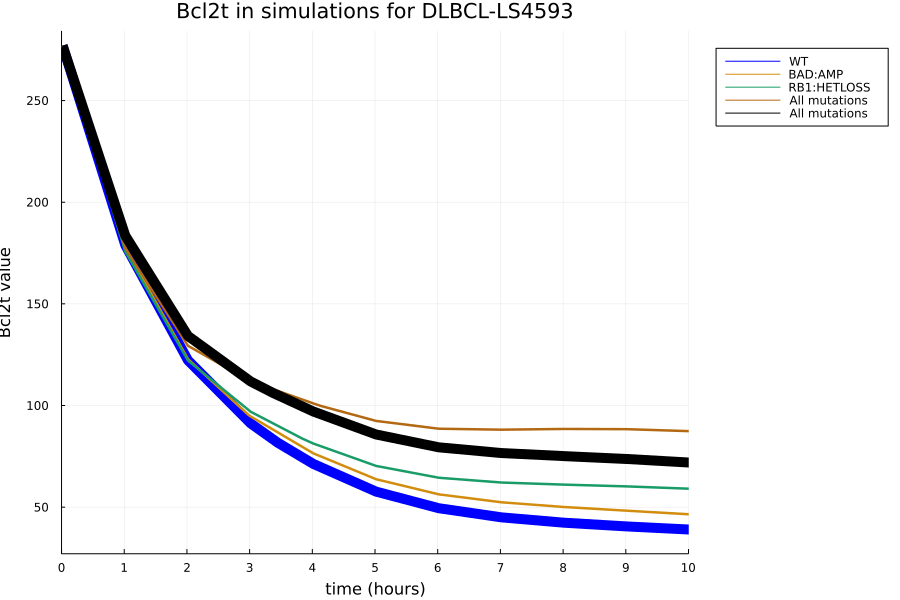

Any["WT", "k2_1a-cellCycle_1.5", "all_mut"]
Any["WT", "CCNB1:AMP", "All mutations"]


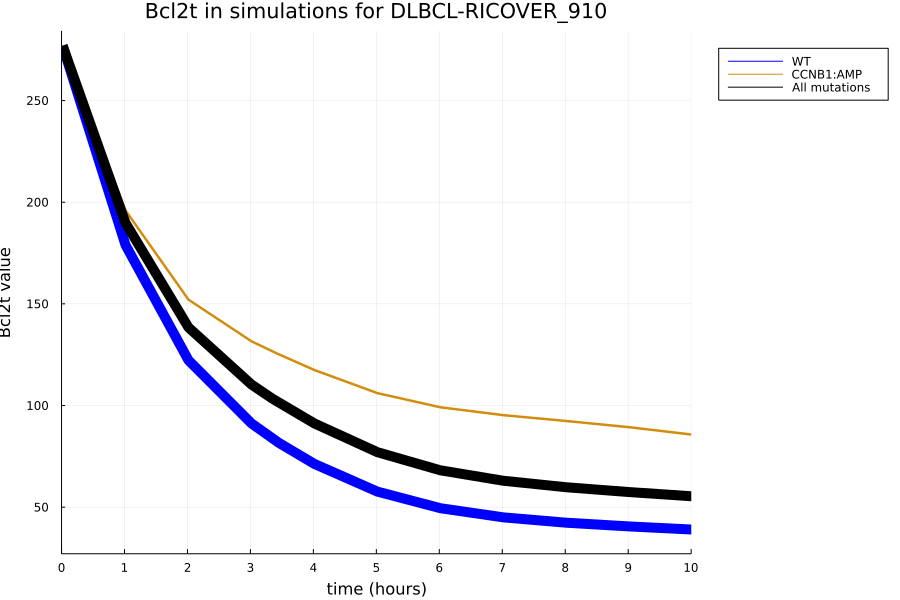

Any["WT", "k1_bcl2Exp-linking_1.5", "k1_s_Blimp1-differentiation_0.5", "k2_5-cellCycle_0.5", "k1_e_pax5-differentiation_0.25", "all_mut"]
Any["WT", "BCL2:AMP", "PRDM1:HETLOSS", "CDKN1B:HETLOSS", "PAX5:X16_splice", "All mutations"]


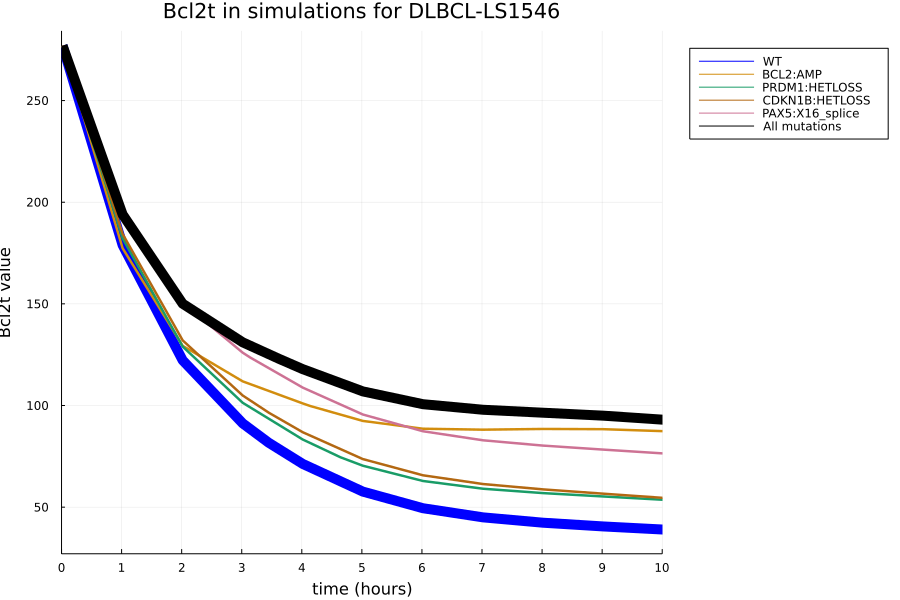

In [24]:
for patient in patients[1:4]
    PlotNFKB(patient, "Bcl2t", 10)
end